# Overview
# CycleGAN from __no-nodule__ to __nodule__ and back

**luna v2**
1. from v1 We multiply some losses by the coefficients shown in the github implementation

**luna v1**
1. applied to LUNA inpainted dataset: (32x32x32) cubes 

**luna v0**
1. applied to LUNA inpainted dataset: (64x64x64) cubes

**v8**
1. Evaluate test set in training loop

**v7**
1. remove the masks from the losses

**v6**
1. We only we used the slices that obtained a successfull qualitative assessment
1. Smaller test subset

**v5**
1. The dataset comes from crop inpainting for gan v3 - (from v2) evaluate pixel differences - use nodule 'nodule to focus on' mask, (saved in 'slices inpainting v9 v3 (crop inpainting for gan v3)'). This dataset takes the correct 64x64 windows using the 'nodule to focus on' mask instead of the segmentation mask
1. Back to original loss weights (from v3)

**v4**
1. Different loss weights

**v3**
1. Working on 64 size images
1. The mask was applied differently. From x * (1 - mask) to x * mask

**v2**    
1. Similarly to deep image prior, we apply a mask to the target loss
1. working with images generated from inpainting v9
1. The dataset class was modified to pad the images to a certain shape limit (so all images are the same shape)

**v1** working with images generated from inpainting v7   

FROM https://github.com/aitorzip/PyTorch-CycleGAN/blob/master   
**CONDA ACTIVATE PYTORCH**

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:
import argparse
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch

from utils_cycleGAN.models import Generator3D
from utils_cycleGAN.models import Discriminator3D
from utils_cycleGAN.utils import ReplayBuffer
from utils_cycleGAN.utils import LambdaLR
from utils_cycleGAN.utils import Logger
from utils_cycleGAN.utils import weights_init_normal
# from datasets import ImageDataset
import pandas as pd

In [2]:
# import visdom
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy import ndimage, optimize
import pdb 
import cv2
import matplotlib.patches as patches
import multiprocessing
import datetime
from tqdm import tqdm_notebook

In [4]:
from torch.utils.data import Dataset, DataLoader
import os
from itertools import product
from utils_cycleGAN.extractRect import *
from torch import Tensor
from torchsummary import summary

In [5]:
nsh = np.shape
def set_all_rcParams(true_or_false):
    rcParams['ytick.left']=true_or_false
    rcParams['xtick.bottom']=true_or_false
    rcParams['ytick.labelleft'] = true_or_false
    rcParams['xtick.labelbottom'] = true_or_false

In [6]:
torch.cuda.set_device(0)

In [7]:
# We need to exclude two folds and save the other gan-created in their corresponding folder
exclude_this_and_previous = 5

In [8]:
epoch=0
epoch_done = -1 # used to continue training from a pretrained network
n_epochs = 401 #original 200 then 401
batchsize = 8
lr=0.0002
decay_epoch = 5 # original 100
size=32
input_nc = 1 # original 3
output_nc = 1 # original 3
cuda = True

In [9]:
# dataroot='datasets
# cuda='use GPU computation')
# n_cpu=8

In [10]:
!pwd

/home/om18/Documents/KCL/Sept 12 19 - LUNA inpainting cycleGAN


In [11]:
# Networks
netG_A2B = Generator3D(input_nc, output_nc)
netG_B2A = Generator3D(output_nc, input_nc)
netD_A = Discriminator3D(input_nc)
netD_B = Discriminator3D(output_nc)

In [12]:
if cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

In [13]:
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

/home/om18/Documents/KCL/Sept 12 19 - LUNA inpainting cycleGAN/utils_cycleGAN/utils.py:114: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.weight.data, 0.0, 0.02)


Discriminator3D(
  (model): Sequential(
    (0): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): InstanceNorm3d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv3d(512, 1, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
  )
)

In [17]:
summary(netD_A, (input_nc,32,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 16, 16, 16]           4,160
         LeakyReLU-2       [-1, 64, 16, 16, 16]               0
            Conv3d-3         [-1, 128, 8, 8, 8]         524,416
    InstanceNorm3d-4         [-1, 128, 8, 8, 8]               0
         LeakyReLU-5         [-1, 128, 8, 8, 8]               0
            Conv3d-6         [-1, 256, 4, 4, 4]       2,097,408
    InstanceNorm3d-7         [-1, 256, 4, 4, 4]               0
         LeakyReLU-8         [-1, 256, 4, 4, 4]               0
            Conv3d-9         [-1, 512, 3, 3, 3]       8,389,120
   InstanceNorm3d-10         [-1, 512, 3, 3, 3]               0
        LeakyReLU-11         [-1, 512, 3, 3, 3]               0
           Conv3d-12           [-1, 1, 2, 2, 2]          32,769
Total params: 11,047,873
Trainable params: 11,047,873
Non-trainable params: 0
-------------------------

In [14]:
netG_A2B

Generator3D(
  (model): Sequential(
    (0): ConstantPad3d(padding=(3, 3, 3, 3, 3, 3), value=0)
    (1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1))
    (2): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace)
    (4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (5): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace)
    (7): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (8): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace)
    (10): ResidualBlock3D(
      (conv_block): Sequential(
        (0): ConstantPad3d(padding=(1, 1, 1, 1, 1, 1), value=0)
        (1): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (2): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inpla

In [16]:
summary(netG_A2B, (input_nc,32,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     ConstantPad3d-1        [-1, 1, 38, 38, 38]               0
            Conv3d-2       [-1, 64, 32, 32, 32]          22,016
    InstanceNorm3d-3       [-1, 64, 32, 32, 32]               0
              ReLU-4       [-1, 64, 32, 32, 32]               0
            Conv3d-5      [-1, 128, 16, 16, 16]         221,312
    InstanceNorm3d-6      [-1, 128, 16, 16, 16]               0
              ReLU-7      [-1, 128, 16, 16, 16]               0
            Conv3d-8         [-1, 256, 8, 8, 8]         884,992
    InstanceNorm3d-9         [-1, 256, 8, 8, 8]               0
             ReLU-10         [-1, 256, 8, 8, 8]               0
    ConstantPad3d-11      [-1, 256, 10, 10, 10]               0
           Conv3d-12         [-1, 256, 8, 8, 8]       1,769,728
   InstanceNorm3d-13         [-1, 256, 8, 8, 8]               0
             ReLU-14         [-1, 256, 

In [16]:
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [17]:
# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

In [18]:
path_source = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/'
path_dest = f'/data/OMM/project results/Feb 20 19 - CycleGan clean/deep nodule prior luna v3 - cubes size 32 coefficients - 10 folds fold{exclude_this_and_previous}/' 
path_quality = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/versions2D/qualitative assessment 1 (passed OM)/'

In [19]:
files = os.listdir(f'{path_source}original')
files = np.sort(files)
files = [i for i in files if 'raw' in i]
print(len(files), files[0])

2292 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860_block1_0_z139y136x29.raw


In [20]:
# QUALITATIVE EVALUATION
files_quality = os.listdir(path_quality)
print(len(files_quality))
files_quality = [f'{i[:-3]}raw' for i in files_quality]
files_common = list(set(files).intersection(set(files_quality)))
print(len(files_common), len(files_common)/len(files))

1801
1801 0.7857766143106457


In [21]:
# GET THE FILES ACCORDING TO 10FOLDS-CV (EXCLUDE VAL AND TEST)
# Get the indices of the folds that should be included AND excluded

fold_excluded, fold_included = [], []
all_fold_exclude = np.arange(0,10)
fold_exclude = all_fold_exclude[exclude_this_and_previous]
fold_excluded.append(fold_exclude)
all_fold_exclude = np.roll(all_fold_exclude,1) # ROLL
fold_exclude = all_fold_exclude[exclude_this_and_previous]
fold_excluded.append(fold_exclude)
fold_included = [i for i in all_fold_exclude if i not in fold_excluded]
fold_excluded, fold_included
# EXCLUDE AND INCLUDE TEST FOLDS
files_fold = files_common
print(f'files after quality approval = {len(files_fold)}')
# EXCLUDE TEST FOLDS
for idx,i in enumerate(fold_excluded):
    path_csv_folds = f'/home/om18/Documents/KCL/Nov 5 2019 - Nodule Detection/LUNA16_nodule_detection/FP_reduction_3_5fold_xval/cycleGAN_augmented/results_fold_{i}/test_results_fold{i}.csv'
    csv_folds = pd.read_csv(path_csv_folds)
    files_in_fold = np.unique(csv_folds['seriesuid'].values)
    files_fold = [i for idx, i in enumerate(files_fold) if i.split('_')[0] not in files_in_fold]
    print(f'files to train after excluding {i} fold = {len(files_fold)}')
# INCLUDE TEST FOLDS
files_in_folds = []
for i in fold_included:
    path_csv_folds = f'/home/om18/Documents/KCL/Nov 5 2019 - Nodule Detection/LUNA16_nodule_detection/FP_reduction_3_5fold_xval/cycleGAN_augmented/results_fold_{i}/test_results_fold{i}.csv'
    csv_folds = pd.read_csv(path_csv_folds)
    files_in_folds += list(np.unique(csv_folds['seriesuid'].values))
    
files_fold = [i for idx, i in enumerate(files_fold) if i.split('_')[0] in files_in_folds]
print(f'files to train after including the {fold_included} = {len(files_fold)}')
files_common = files_fold

files after quality approval = 1801
files to train after excluding 5 fold = 1626
files to train after excluding 4 fold = 1456
files to train after including the [9, 0, 1, 2, 3, 6, 7, 8] = 1456


In [22]:
print(f'fold_excluded = {fold_excluded}')
print(f'fold_included = {fold_included}')

fold_excluded = [5, 4]
fold_included = [9, 0, 1, 2, 3, 6, 7, 8]


### main

In [23]:
fold = 1
np.random.seed(fold)
files_train, files_test = train_test_split(files_common, test_size=0.003, random_state=fold)
files_train = np.sort(files_train)
files_test = np.sort(files_test)

In [24]:
len(files_train), len(files_test)

(1451, 5)

In [25]:
# Since we are using ReplayBuffer we need to make sure our minibatches have the correct size
batch_size_remainder_train = len(files_train) % batchsize
batch_size_remainder_test = len(files_test) % batchsize
files_train = files_train[:-batch_size_remainder_train]
files_test = files_test[:-batch_size_remainder_test]
len(files_train), len(files_test)

(1448, 0)

In [26]:
# # Save the files that were also analyzed (malignancy classification) in the inpainting part
# df_qc_3agree = pd.read_csv('/data/OMM/Datasets/LIDC_other_formats/LIDC_inpainted_malignancy_classification 2D - for workshop/df_QC_3agree.csv')
# df_qc_3agree_names = df_qc_3agree.names.values
# len(df_qc_3agree), df_qc_3agree_names[0]

# # files_check = [i.split('.')[0] for idx, i in enumerate(files_train) if idx % 4 == 0]
# # len(files_check)

# files_check = [i.split('.')[0] for i in files_train if i.split('.')[0] in df_qc_3agree_names]
# len(files_check)

In [27]:
class LIDCGAN_dataready(Dataset):
    def __init__(self, files_train_test, transform = False):
        self.A = [f'{path_source}original/{i}' for i in files_train_test]
        self.B = [f"{path_source}inpainted inserted/{i}" for i in files_train_test]
        self.mask = [f"{path_source}mask/{i}" for i in files_train_test]
        self.transform = transform
        
    def __len__(self):
        return len(self.A)
    
    def normalizePatches(self, npzarray):
        maxHU = 400.
        minHU = -1000.

        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def rotate_and_flip(self, image1, image2, image3):
        rand_int = np.random.randint(1,4)
        if np.random.rand() > .3:
            image1 = np.rot90(image1,rand_int).copy()
            image2 = np.rot90(image2,rand_int).copy()
            image3 = np.rot90(image3,rand_int).copy()
        if np.random.rand() > .5:
            image1 = np.flip(image1,0).copy()
            image2 = np.flip(image2,0).copy()
            image3 = np.flip(image3,0).copy()
        if np.random.rand() > .5:
            image1 = np.flip(image1,1).copy()
            image2 = np.flip(image2,1).copy()
            image3 = np.flip(image3,1).copy()
        return image1, image2, image3
                              
    def __getitem__(self, idx):
        imgA = np.fromfile(self.A[idx],dtype='int16').astype('float32').reshape((64,64,64))
        imgB = np.fromfile(self.B[idx],dtype='int16').astype('float32').reshape((64,64,64))
        mask = np.fromfile(self.mask[idx],dtype='int16').astype('float32').reshape((64,64,64))
        
        # v1: ONLY USE THE INSIDE OF THE CUBE (32x32x32 size)
        imgA = imgA[16:-16,16:-16,16:-16]
        imgB = imgB[16:-16,16:-16,16:-16]
        mask = mask[16:-16,16:-16,16:-16]
        
        # normalize
        imgA = self.normalizePatches(imgA)
        imgB = self.normalizePatches(imgB) 
        
        # Flips
        if self.transform:
            imgA, imgB, mask = self.rotate_and_flip(imgA, imgB, mask)
                    
        # Add channels dimension
        imgA = np.expand_dims(imgA,0)
        imgB = np.expand_dims(imgB,0)
        mask = np.expand_dims(mask,0)
        
        # Pytorch
        imgA = Tensor(imgA)
        imgB = Tensor(imgB)
        mask = Tensor(mask)
                  
        # Get name to save the data                      
#         name = self.A[idx].split('orig/')[-1]
        name = self.A[idx]
    
        return imgA, imgB, mask, name

In [28]:
dataset_train = LIDCGAN_dataready(files_train, transform=False)

In [29]:
dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=False)

In [30]:
slice_middle = 15
def plot_next_batch_dataloader(dataloader_iterX):
    a, b, mask, name = next(dataloader_iterX)
    print(np.shape(a), np.shape(b), np.shape(mask))
    for i,j,k in zip(a,b,mask):
        fig, ax = plt.subplots(1,4,figsize=(10,5))
        i = i[0].detach().cpu().numpy()
        j = j[0].detach().cpu().numpy()
        k = k[0].detach().cpu().numpy()
        print(np.shape(i), np.shape(j), np.shape(k))
        new_name = name[0].split('/')[-1][:-4]
        ax[0].imshow(i[slice_middle], vmin=0, vmax=1)
        ax[1].imshow(j[slice_middle], vmin=0, vmax=1)
        ax[2].imshow(np.abs(i[slice_middle]-j[slice_middle]), vmin=0, vmax=.1)
        ax[3].imshow(k[slice_middle])
        fig.tight_layout()

In [31]:
def shape_next_batch_dataloader(dataloader_iterX):
    a, b, mask, name = next(dataloader_iterX)
    for i,j,k in zip(a,b,mask):
        print(i.shape)
        print(j.shape)

In [32]:
dataloader_iter = iter(dataloader_train)

torch.Size([8, 1, 32, 32, 32]) torch.Size([8, 1, 32, 32, 32]) torch.Size([8, 1, 32, 32, 32])
(32, 32, 32) (32, 32, 32) (32, 32, 32)
(32, 32, 32) (32, 32, 32) (32, 32, 32)
(32, 32, 32) (32, 32, 32) (32, 32, 32)
(32, 32, 32) (32, 32, 32) (32, 32, 32)
(32, 32, 32) (32, 32, 32) (32, 32, 32)
(32, 32, 32) (32, 32, 32) (32, 32, 32)
(32, 32, 32) (32, 32, 32) (32, 32, 32)
(32, 32, 32) (32, 32, 32) (32, 32, 32)


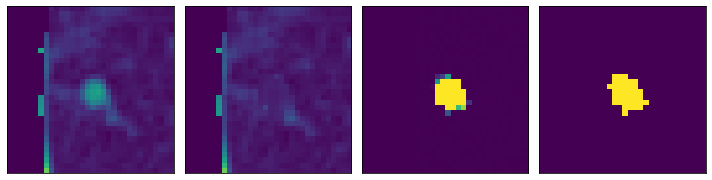

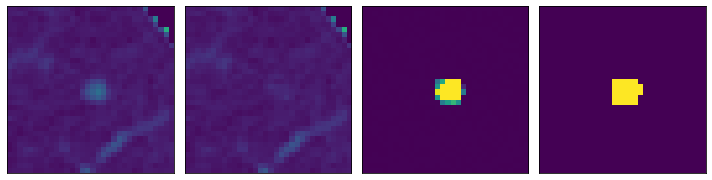

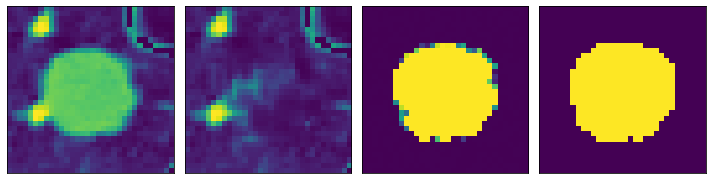

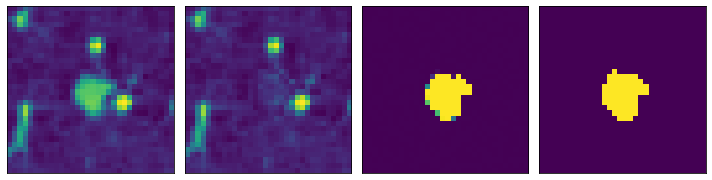

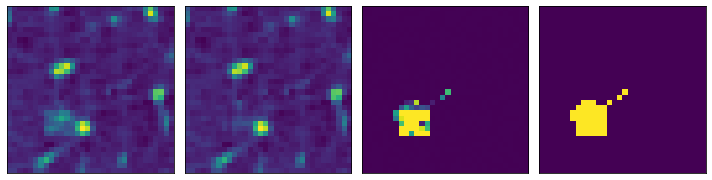

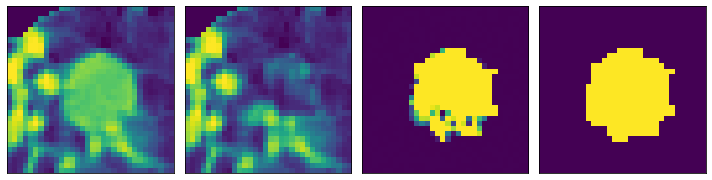

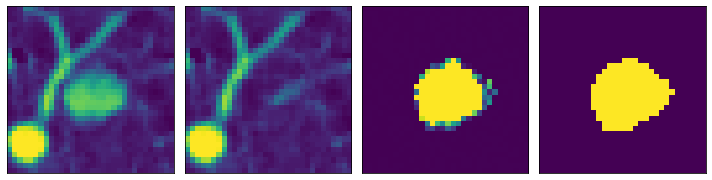

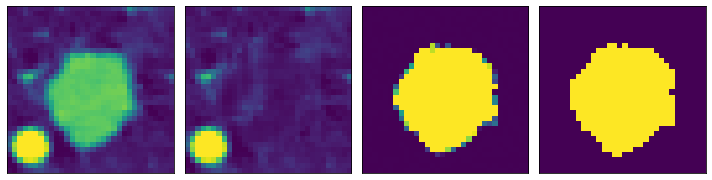

In [33]:
set_all_rcParams(False)
plot_next_batch_dataloader(dataloader_iter)
# plot_next_batch_dataloader(dataloader_iter)

In [34]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
input_A = Tensor(batchsize, input_nc, 32, 32, 32)
input_B = Tensor(batchsize, input_nc, 32, 32, 32)
target_real = Variable(Tensor(batchsize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchsize).fill_(0.0), requires_grad=False)

In [35]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [36]:
# def save_generated_images(name, files_to_check):
    
#     if name in files_to_check:        
#         np.save(f'{path_dest}A/{name}_ep{epoch:03d}',fake_A)
#         np.save(f'{path_dest}B/{name}_ep{epoch:03d}',fake_B)

In [37]:
path_netG_A2B = f'{path_dest}models/netG_A2B.pth'
path_netG_B2A = f'{path_dest}models/netG_B2A.pth'
path_netD_A = f'{path_dest}models/netD_A.pth'
path_netD_B = f'{path_dest}models/netD_B.pth'

In [38]:
dataset_test = LIDCGAN_dataready(files_test, transform=False)
dataloader_test = DataLoader(dataset_test, batch_size=batchsize, shuffle=False)

In [39]:
# to continue training
try:
    epoch_done = int(np.load(f'{path_dest}models/last_epoch.npy'))
    netG_A2B.load_state_dict(torch.load(path_netG_A2B))
    netG_B2A.load_state_dict(torch.load(path_netG_B2A))
    netD_A.load_state_dict(torch.load(path_netD_A))
    netD_B.load_state_dict(torch.load(path_netD_B))
    loss_G_all = np.load(f'{path_dest}metrics/loss_G_all.npy')
    loss_G_identity_all = np.load(f'{path_dest}metrics/loss_G_identity_all.npy')
    loss_G_GAN_all = np.load(f'{path_dest}metrics/loss_G_GAN_all.npy')
    loss_G_cycle_all = np.load(f'{path_dest}metrics/loss_G_cycle_all.npy')
    loss_D_all = np.load(f'{path_dest}metrics/loss_D_all.npy')
    loss_G_all = np.expand_dims(loss_G_all,-1).tolist()
    loss_G_identity_all = np.expand_dims(loss_G_identity_all,-1).tolist()
    loss_G_GAN_all = np.expand_dims(loss_G_GAN_all,-1).tolist()
    loss_G_cycle_all = np.expand_dims(loss_G_cycle_all,-1).tolist()
    loss_D_all = np.expand_dims(loss_D_all,-1).tolist()
except FileNotFoundError:
    epoch_done = -1
    loss_G_all = []
    loss_G_identity_all = []
    loss_G_GAN_all = []
    loss_G_cycle_all = []
    loss_D_all = []
print(epoch_done)

-1


In [40]:
path_dest

'/data/OMM/project results/Feb 20 19 - CycleGan clean/deep nodule prior luna v3 - cubes size 32 coefficients - 10 folds fold5/'

In [41]:
# path_test_output = f'{path_dest}test output/'

for epoch in tqdm_notebook(range(n_epochs)):
    if epoch <=  epoch_done: continue
    #if epoch==1:break
    print(f'epoch = {epoch}')
    # A = original
    # B = inpainted
    for i, (A, B, mask, name) in tqdm_notebook(enumerate(dataloader_train), total= dataloader_train.dataset.__len__() // batchsize):
        netG_A2B.train()
        netG_B2A.train()
        netD_A.train()
        netD_B.train()
        
        # Set model input
        real_A = Variable(input_A.copy_(A))
        real_B = Variable(input_B.copy_(B))
        #pdb.set_trace()
        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B) # OMM
        loss_identity_B = criterion_identity(same_B, real_B) * 5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A) # OMM
        loss_identity_A = criterion_identity(same_A, real_A) * 5.0

        # GAN loss
        fake_B = netG_A2B(real_A) # OMM # 
        pred_fake = netD_B(fake_B)
        pred_fake.squeeze_() # OMM
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B) # OMM # 
        pred_fake = netD_A(fake_A)
        pred_fake.squeeze_() # OMM
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B) # OMM
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * 10.0

        recovered_B = netG_A2B(fake_A) # OMM
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * 10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        pred_real.squeeze_() # OMM
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        pred_fake.squeeze_() # OMM
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake) * 0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        pred_real.squeeze_() # OMM
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        pred_fake.squeeze_() # OMM
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake) * 0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################
        
        # Save results
        loss_G_all.append(loss_G.detach().cpu().numpy())
        loss_G_identity_all.append((loss_identity_A.detach().cpu().numpy() + loss_identity_B.detach().cpu().numpy()))
        loss_G_GAN_all.append((loss_GAN_A2B.detach().cpu().numpy() + loss_GAN_B2A.detach().cpu().numpy()))
        loss_G_cycle_all.append((loss_cycle_ABA.detach().cpu().numpy() + loss_cycle_BAB.detach().cpu().numpy()))
        loss_D_all.append((loss_D_A.detach().cpu().numpy() + loss_D_B.detach().cpu().numpy()))

                # Save generated images (from a few examples)
        if epoch % 2 == 0:
            
            # save metrics
            loss_G_all_squeezed = np.squeeze(loss_G_all)
            loss_G_identity_all_squeezed = np.squeeze(loss_G_identity_all)
            loss_G_GAN_all_squeezed = np.squeeze(loss_G_GAN_all)
            loss_G_cycle_all_squeezed = np.squeeze(loss_G_cycle_all)
            loss_D_all_squeezed = np.squeeze(loss_D_all)
            np.save(f'{path_dest}metrics/loss_G_all',loss_G_all_squeezed)
            np.save(f'{path_dest}metrics/loss_G_identity_all',loss_G_identity_all_squeezed)
            np.save(f'{path_dest}metrics/loss_G_GAN_all',loss_G_GAN_all_squeezed)
            np.save(f'{path_dest}metrics/loss_G_cycle_all',loss_G_cycle_all_squeezed)
            np.save(f'{path_dest}metrics/loss_D_all',loss_D_all_squeezed)
            
            
            for iA, iB, i_name in zip(fake_A, fake_B, name):
                
                iA = np.squeeze(iA.detach().cpu().numpy())
                iB = np.squeeze(iB.detach().cpu().numpy())
                i_name = i_name.split('/')[-1]
                
                iA.tofile(f'{path_dest}A/{i_name}_ep{epoch:03d}') # SAVE THE IMAGES!!!!!
#                 iB.tofile(f'{path_dest}B/{i_name}_ep{epoch:03d}')
                
            
            
            
#             new_name = name[0].split('/')[-1][:-4]
# #             if new_name in files_check: # WE NOW SAVE ALL ITERATIONS
#             np.save(f'{path_dest}A/{new_name}_ep{epoch:03d}',fake_A)
#             np.save(f'{path_dest}B/{new_name}_ep{epoch:03d}',fake_B)
        
    # Test sets 
#     netG_A2B.eval()
#     netG_B2A.eval()
        
#     # Inputs & targets memory allocation
#     input_A_test = Tensor(batchsize, input_nc, 64, 64)
#     input_B_test = Tensor(batchsize, output_nc, 64, 64)
    
#     for i, (A, B, mask, name) in enumerate(dataloader_test):
#         # Set model input
#         real_A = Variable(input_A_test.copy_(A))
#         real_B = Variable(input_B_test.copy_(B))

#         # Generate output # OMM the original equation was modified
#         fake_B = (netG_A2B(real_A).data) # 0.5*(netG_A2B(real_A).data + 1.0) <-original equation
#         fake_A = (netG_B2A(real_B).data)
#         new_name = name[0].split('/')[-1][:-4]
#         # Save output
#         np.save(f'{path_test_output}A/{new_name}_ep{epoch:03d}', fake_A)
#         np.save(f'{path_test_output}B/{new_name}_ep{epoch:03d}', fake_B)
    

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), path_netG_A2B)
    torch.save(netG_B2A.state_dict(), path_netG_B2A)
    torch.save(netD_A.state_dict(), path_netD_A)
    torch.save(netD_B.state_dict(), path_netD_B)
    np.save(f'{path_dest}models/last_epoch.npy', epoch)

epoch = 0


FileNotFoundError: [Errno 2] No such file or directory: '/data/OMM/project results/Feb 20 19 - CycleGan clean/deep nodule prior luna v3 - cubes size 32 coefficients - 10 folds fold5/metrics/loss_G_all.npy'

In [ ]:
/data/OMM/project results/Feb 20 19 - CycleGan clean/
deep nodule prior luna v3 - cubes size 32 coefficients - 10 folds